# Notebook 5 - Building ML models for the windfarm dataset

Now let's get cracking. Here we will build different models, just as we have done for the first dataset. We will also try to learn something about the dataset.

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD, Adam

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
DATADIR = './dataset2/'

In [72]:
with open('./tmp/wind_ds_clean.pkl', 'rb') as f:
    X_train, Xobs_train, y_train, X_valid, Xobs_valid, y_valid, X_test, Xobs_test = pickle.load(f)

In [3]:
with open('./tmp/test_times.pkl', 'rb') as f:
    test_times = pickle.load(f)

In [73]:
X_train.shape, Xobs_train.shape, y_train.shape, X_valid.shape

((2507, 210), (3368, 24), (2507, 33), (199, 210))

In [69]:
X_train.mean(), X_valid.mean()

(163.43726, 163.98079)

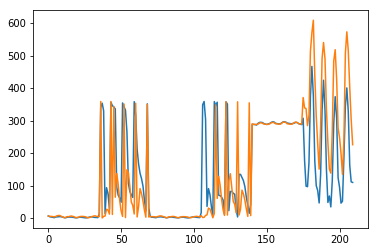

In [71]:
plt.plot(X_train[0])
plt.plot(X_valid[0])

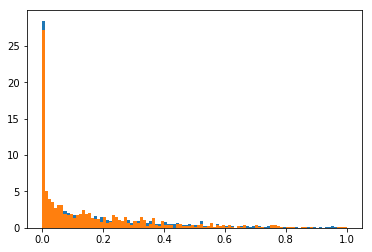

In [65]:
plt.hist(y_train.flatten(), bins=100, density=True, range=(0,1));
plt.hist(y_valid.flatten(), bins=100, density=True, range=(0,1));

In [66]:
def mse(y_true, y_pred, axis=(0,1)): return ((y_true - y_pred)**2).mean(axis)
def rmse(y_true, y_pred, axis=(0,1)): return np.sqrt(((y_true - y_pred)**2).mean(axis))
def create_sub(preds, fn=None):
    """Sorry for the complicated submission format. But just use this function """
    time_string = [
        f'{str(tt)[:13]}+{str(lt).zfill(2)}h' for tt, lt 
        in zip(np.repeat(test_times, 33), np.tile(np.arange(0, 33*3,3), len(test_times)))]
    df =  pd.DataFrame({'Time': time_string, 'Expected': np.ravel(preds)})
    if fn is not None: df.to_csv(DATADIR + fn, index=False)
    return df

## Linear regression

Let's start out again with a simple linear regression model. It is always good to start with the dumbest model possible to create a benchmark.

### Normalize the dataset

Recall that for linear regression and neural networks we need to normalize our input data.

In [74]:
# Remember to use the same mean and std for all datasets
mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

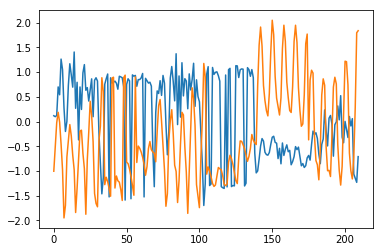

In [75]:
plt.plot(X_train[-1])
plt.plot(X_valid[0])

### Train the model

Now we proceed as before.

In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
def print_scores(m, X_train=X_train, X_valid=X_valid):
    print('Train R2 = ', m.score(X_train, y_train), 
          ', Valid R2 = ', m.score(X_valid, y_valid), ', Valid RMSE = ', 
          rmse(m.predict(X_valid), y_valid))

In [78]:
print_scores(lr)

Train R2 =  0.5513176563365674 , Valid R2 =  0.4438317095920031 , Valid RMSE =  0.1655196


### Check the prediction against lead time

In [11]:
def plot_rmse_lead(y_true, y_pred, label=None):
    plt.plot(np.arange(0, y_true.shape[1]*3, 3), rmse(y_true, y_pred, 0), label=label)
    plt.xlabel('Lead time'); plt.ylabel('RMSE'); 
    if label is not None: plt.legend()

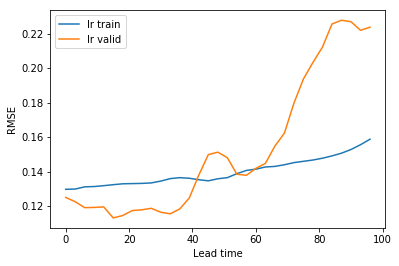

In [24]:
plot_rmse_lead(y_train, lr.predict(X_train), 'lr train')
plot_rmse_lead(y_valid, lr.predict(X_valid), 'lr valid')

We can see that the error goes up with time, just as we would expect.

### Create submission

In [14]:
df = create_sub(lr.predict(X_test), 'lr.csv')

In [18]:
df.head()

,Time,Expected
0,2015-03-01T00+00h,0.165771
1,2015-03-01T00+03h,0.068826
2,2015-03-01T00+06h,-0.031473
3,2015-03-01T00+09h,0.063573
4,2015-03-01T00+12h,0.145086


## Random forest

We already know that we can probably do better with a random forest. Se let's simply try our setting from the previous notebook.

In [44]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [45]:
%time rf.fit(X_train, y_train)

CPU times: user 25.1 s, sys: 8 ms, total: 25.1 s
Wall time: 1.54 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
print_scores(rf)

Train R2 =  0.5558734975780655 , Valid R2 =  0.3607712736600619 , Valid RMSE =  0.1542913666129775


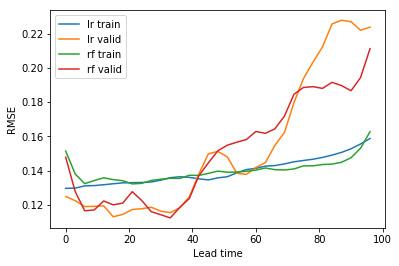

In [47]:
plot_rmse_lead(y_train, lr.predict(X_train), 'lr train')
plot_rmse_lead(y_valid, lr.predict(X_valid), 'lr valid')
plot_rmse_lead(y_train, rf.predict(X_train), 'rf train')
plot_rmse_lead(y_valid, rf.predict(X_valid), 'rf valid')

Well, that is not very good. Even the training score is not better than for linear regression. This tells us that there is some underfitting going on. Let's try to increase the complexity of the forest.

### A more complex forest.

In [48]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=2)

In [49]:
%time rf.fit(X_train, y_train)

CPU times: user 35.6 s, sys: 0 ns, total: 35.6 s
Wall time: 2.24 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
print_scores(rf)

Train R2 =  0.8023942873688403 , Valid R2 =  0.3898567809297109 , Valid RMSE =  0.15074030112666972


That's already better but now we are overfitting like crazy. Let's increase the number of trees.

In [54]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, min_samples_leaf=2)

In [55]:
%time rf.fit(X_train, y_train)

CPU times: user 3min 55s, sys: 64 ms, total: 3min 55s
Wall time: 12.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
print_scores(rf)

Train R2 =  0.8085970196578686 , Valid R2 =  0.39821188126882834 , Valid RMSE =  0.14970464941227196


Ok, so that's better but the overfitting problem is huge. This might be due to the limited amount of training data or because I don't know what I am doing... 

In [57]:
df = create_sub(rf.predict(X_test), 'rf.csv')

Surprisingly, the test score on kaggle for the random forest is worse that the linear regression score. Does this mean that we have not chosen our validation dataset correctly? 

As you can see, real machine learning problems are hard and a lot of the time is spent on wondering what the hell is going on. 

## Neural networks in sklearn

Ok, so now let's start with a neural network. At first, let's actually try something different and use the sklearn MLP class. It's very unflexible but has some good defaults for simple problems like ours.

In [58]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=200)

In [59]:
%time nn.fit(X_train, y_train)

CPU times: user 13.1 s, sys: 124 ms, total: 13.2 s
Wall time: 1.32 s


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[32, 32], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [60]:
print_scores(nn)

Train R2 =  0.4836062585782892 , Valid R2 =  0.28904653812289294 , Valid RMSE =  0.16271742788624444


In [47]:
nn = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='linear')
])

In [48]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               50944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8224      
Total params: 59,168
Trainable params: 59,168
Non-trainable params: 0
_________________________________________________________________


In [49]:
nn.compile(Adam(1e-3), 'mse')

In [50]:
nn.fit(X_train, y_train, 1024, epochs=1000, validation_data=(X_valid, y_valid))

Train on 2913 samples, validate on 961 samples
Epoch 1/1000
2913/2913 [==============================] - 0s 108us/step - loss: 2.9396 - val_loss: 0.8321
Epoch 2/1000
2913/2913 [==============================] - 0s 7us/step - loss: 1.9778 - val_loss: 0.5659
Epoch 3/1000
2913/2913 [==============================] - 0s 8us/step - loss: 1.6144 - val_loss: 0.4955
Epoch 4/1000
2913/2913 [==============================] - 0s 8us/step - loss: 1.3929 - val_loss: 0.4116
Epoch 5/1000
2913/2913 [==============================] - 0s 9us/step - loss: 1.1571 - val_loss: 0.3267
Epoch 6/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.9445 - val_loss: 0.2661
Epoch 7/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.8068 - val_loss: 0.2299
Epoch 8/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.7140 - val_loss: 0.2039
Epoch 9/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.6411 - val_loss: 0.1800
Epoch 10/1000
2

2913/2913 [==============================] - 0s 8us/step - loss: 0.0340 - val_loss: 0.0248
Epoch 156/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0344 - val_loss: 0.0247
Epoch 157/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0340 - val_loss: 0.0248
Epoch 158/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0337 - val_loss: 0.0247
Epoch 159/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0337 - val_loss: 0.0246
Epoch 160/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0332 - val_loss: 0.0246
Epoch 161/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0331 - val_loss: 0.0247
Epoch 162/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0328 - val_loss: 0.0247
Epoch 163/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0327 - val_loss: 0.0247
Epoch 164/1000
2913/2913 [==============================] - 0

2913/2913 [==============================] - 0s 10us/step - loss: 0.0229 - val_loss: 0.0246
Epoch 310/1000
2913/2913 [==============================] - 0s 10us/step - loss: 0.0232 - val_loss: 0.0246
Epoch 311/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0230 - val_loss: 0.0245
Epoch 312/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0229 - val_loss: 0.0245
Epoch 313/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0230 - val_loss: 0.0245
Epoch 314/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0229 - val_loss: 0.0246
Epoch 315/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0228 - val_loss: 0.0246
Epoch 316/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0230 - val_loss: 0.0246
Epoch 317/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0230 - val_loss: 0.0246
Epoch 318/1000
2913/2913 [==============================] -

2913/2913 [==============================] - 0s 10us/step - loss: 0.0214 - val_loss: 0.0246
Epoch 464/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0213 - val_loss: 0.0247
Epoch 465/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0213 - val_loss: 0.0246
Epoch 466/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0215 - val_loss: 0.0246
Epoch 467/1000
2913/2913 [==============================] - 0s 10us/step - loss: 0.0214 - val_loss: 0.0246
Epoch 468/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0213 - val_loss: 0.0246
Epoch 469/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0214 - val_loss: 0.0247
Epoch 470/1000
2913/2913 [==============================] - 0s 10us/step - loss: 0.0214 - val_loss: 0.0248
Epoch 471/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0213 - val_loss: 0.0248
Epoch 472/1000
2913/2913 [==============================] 

2913/2913 [==============================] - 0s 8us/step - loss: 0.0210 - val_loss: 0.0247
Epoch 618/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0209 - val_loss: 0.0247
Epoch 619/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0209 - val_loss: 0.0247
Epoch 620/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0208 - val_loss: 0.0247
Epoch 621/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0209 - val_loss: 0.0247
Epoch 622/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0210 - val_loss: 0.0248
Epoch 623/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0210 - val_loss: 0.0248
Epoch 624/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0211 - val_loss: 0.0248
Epoch 625/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0210 - val_loss: 0.0247
Epoch 626/1000
2913/2913 [==============================] - 0

2913/2913 [==============================] - 0s 10us/step - loss: 0.0207 - val_loss: 0.0250
Epoch 772/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0208 - val_loss: 0.0249
Epoch 773/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0208 - val_loss: 0.0251
Epoch 774/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0207 - val_loss: 0.0251
Epoch 775/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0208 - val_loss: 0.0250
Epoch 776/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0209 - val_loss: 0.0249
Epoch 777/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0208 - val_loss: 0.0250
Epoch 778/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0207 - val_loss: 0.0250
Epoch 779/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0208 - val_loss: 0.0249
Epoch 780/1000
2913/2913 [==============================] - 

2913/2913 [==============================] - 0s 7us/step - loss: 0.0207 - val_loss: 0.0251
Epoch 926/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0206 - val_loss: 0.0252
Epoch 927/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0207 - val_loss: 0.0251
Epoch 928/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0207 - val_loss: 0.0250
Epoch 929/1000
2913/2913 [==============================] - 0s 7us/step - loss: 0.0207 - val_loss: 0.0251
Epoch 930/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0208 - val_loss: 0.0250
Epoch 931/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0206 - val_loss: 0.0252
Epoch 932/1000
2913/2913 [==============================] - 0s 8us/step - loss: 0.0207 - val_loss: 0.0254
Epoch 933/1000
2913/2913 [==============================] - 0s 9us/step - loss: 0.0208 - val_loss: 0.0251
Epoch 934/1000
2913/2913 [==============================] - 0

**@MARTIN**

Ich kann mit einem NN im ersten Versuch keine besseren Ergebnisse erzielen wie mit dem RF. Die Datenmenge ist natuerlich auch richtig klein. Hast du Tipps?

In [51]:
356*24//3

2848